In [421]:
# 1. Import the Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [422]:
#2. Load traning data
dataset_train = pd.read_csv("CBOE_VIX_TRAIN.csv")
dataset_train['Close'] = pd.to_numeric(dataset_train.Close, errors = 'coerce')
dataset_train.dropna(axis=0, how='all')
dataset_train.head()

,Date,Open,High,Low,Close
0,2019/11/1,12.50,12.60,12.26,12.30
1,2019/11/4,12.68,13.13,12.44,12.83
2,2019/11/5,12.85,13.28,12.25,13.10
3,2019/11/6,13.18,13.39,12.60,12.62
4,2019/11/7,12.59,12.89,12.26,12.73


In [423]:
# 3. Use the close stock price column to train the model
training_set = dataset_train.iloc[:,4:5].values

print(training_set)
print(training_set.shape)

[[12.3     ]
 [12.83    ]
 [13.1     ]
 [12.62    ]
 [12.73    ]
 [12.07    ]
 [12.69    ]
 [12.68    ]
 [13.      ]
 [13.05    ]
 [12.05    ]
 [12.46    ]
 [12.86    ]
 [12.78    ]
 [13.13    ]
 [12.34    ]
 [11.87    ]
 [11.54    ]
 [11.75    ]
 [12.62    ]
 [14.91    ]
 [15.96    ]
 [14.8     ]
 [14.52    ]
 [13.62    ]
 [15.86    ]
 [15.68    ]
 [14.99    ]
 [13.94    ]
 [12.63    ]
 [12.14    ]
 [12.29    ]
 [12.58    ]
 [12.5     ]
 [12.51    ]
 [12.61    ]
 [12.67    ]
 [12.65    ]
 [13.43    ]
 [14.82    ]
 [13.78    ]
 [12.47    ]
 [14.02    ]
 [13.85    ]
 [13.79    ]
 [13.45    ]
 [12.54    ]
 [12.56    ]
 [12.32    ]
 [12.39    ]
 [12.42    ]
 [12.32    ]
 [12.1     ]
 [12.85    ]
 [12.91    ]
 [12.98    ]
 [14.56    ]
 [18.23    ]
 [16.280001]
 [16.389999]
 [15.49    ]
 [18.84    ]
 [17.969999]
 [16.049999]
 [15.15    ]
 [14.96    ]
 [15.47    ]
 [15.04    ]
 [15.18    ]
 [13.74    ]
 [14.15    ]
 [13.68    ]
 [14.83    ]
 [14.38    ]
 [15.56    ]
 [17.08    ]
 [25.030001]

In [424]:
# 4. Normalizing the dataset
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled_training_set = scaler.fit_transform(training_set)

scaled_training_set

array([[0.01068166],
       [0.01813071],
       [0.02192551],
       [0.0151792 ],
       [0.01672523],
       [0.00744905],
       [0.01616304],
       [0.01602249],
       [0.02052003],
       [0.02122277],
       [0.00716795],
       [0.01293043],
       [0.01855235],
       [0.01742797],
       [0.02234715],
       [0.01124385],
       [0.00463809],
       [0.        ],
       [0.00295151],
       [0.0151792 ],
       [0.04736472],
       [0.06212228],
       [0.04581869],
       [0.04188334],
       [0.02923401],
       [0.06071679],
       [0.05818693],
       [0.04848911],
       [0.03373155],
       [0.01531975],
       [0.00843289],
       [0.01054111],
       [0.01461701],
       [0.01349262],
       [0.01363317],
       [0.01503865],
       [0.01588194],
       [0.01560084],
       [0.0265636 ],
       [0.04609979],
       [0.03148278],
       [0.01307098],
       [0.03485594],
       [0.03246662],
       [0.03162333],
       [0.02684469],
       [0.01405481],
       [0.014

In [425]:
# 5. Creating X_train and y_train data structure
X_train = []
y_train = []
for i in range(60, 531):
    X_train.append(scaled_training_set[i-60:i, 0])
    y_train.append(scaled_training_set[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(471, 60)
(471,)


In [426]:
# 6. Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape

(471, 60, 1)

In [427]:
# 7. Building the Model by Importing the Crucial Libraries and Adding Different Layers to LSTM.
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [428]:
regressor = Sequential()

regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 100, return_sequences = False))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [429]:
# 8. Fitting the Model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 2)

Epoch 1/100
15/15 - 6s - loss: 0.0209 - 6s/epoch - 368ms/step
Epoch 2/100
15/15 - 1s - loss: 0.0120 - 1s/epoch - 71ms/step
Epoch 3/100
15/15 - 1s - loss: 0.0084 - 1s/epoch - 76ms/step
Epoch 4/100
15/15 - 1s - loss: 0.0081 - 1s/epoch - 78ms/step
Epoch 5/100
15/15 - 1s - loss: 0.0062 - 1s/epoch - 74ms/step
Epoch 6/100
15/15 - 1s - loss: 0.0061 - 1s/epoch - 71ms/step
Epoch 7/100
15/15 - 1s - loss: 0.0058 - 1s/epoch - 73ms/step
Epoch 8/100
15/15 - 1s - loss: 0.0050 - 1s/epoch - 81ms/step
Epoch 9/100
15/15 - 1s - loss: 0.0049 - 1s/epoch - 74ms/step
Epoch 10/100
15/15 - 1s - loss: 0.0048 - 1s/epoch - 73ms/step
Epoch 11/100
15/15 - 1s - loss: 0.0053 - 1s/epoch - 73ms/step
Epoch 12/100
15/15 - 1s - loss: 0.0053 - 1s/epoch - 74ms/step
Epoch 13/100
15/15 - 1s - loss: 0.0054 - 1s/epoch - 76ms/step
Epoch 14/100
15/15 - 1s - loss: 0.0055 - 1s/epoch - 74ms/step
Epoch 15/100
15/15 - 1s - loss: 0.0047 - 1s/epoch - 73ms/step
Epoch 16/100
15/15 - 1s - loss: 0.0041 - 1s/epoch - 72ms/step
Epoch 17/100
15/

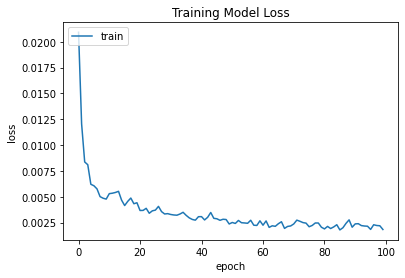

In [430]:
# Plot the loss reduction path by epochs
plt.plot(hist.history['loss'])
plt.title('Training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [431]:
# 9. Ectracting the actual 
testData = pd.read_csv('CBOE_VIX_TEST.csv')
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce')
testData = testData.dropna()
testData = testData.iloc[:,4:5]
y_test = testData.iloc[60:,0:].values 

# 10. Preparing the Input for the Model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = scaler.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length):  
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(170, 60, 1)

In [432]:
# Predicting the value for VIX Oct. and Nov.
y_pred = regressor.predict(X_test)
predicted_price = scaler.inverse_transform(y_pred)

6/6 [==============================] - 1s 19ms/step


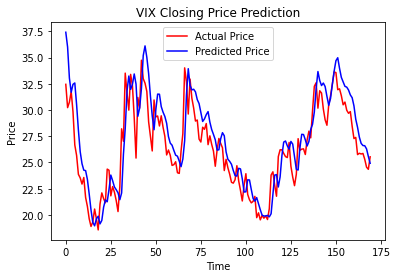

In [433]:
# 12. Plotting the Actual and Predicted Prices for VIX.
plt.plot(y_test, color = 'red', label = 'Actual Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('VIX Closing Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [434]:
MSE = np.square(np.subtract(y_test, predicted_price)).mean()
print(MSE)

5.230126417752054
